In [13]:
# demo a squared exponential GP on the axial dataset, measure interp and extrap error
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("src/")
from closed_form_dataset import get_closed_form_data, split_data, nan_extrap_data
from plot_utils import plot_surface

# inputs:
# ----------------------
axial = True
affine = True
log = True

# hyperparameters
th = np.array([3.0, 3.0, 1.0])
sigma_n = 1e-4

In [14]:
# get dataset:
# ------------------------------

# get only interp data
X, Y = get_closed_form_data(
    axial=axial, include_extrapolation=False, 
    affine_transform=affine, 
    log_transform=log,
    # no need for nan_interp, nan_extrap inputs yet that's for plotting
    n_rho0=20, n_gamma=10, n_xi=5,
)

# now split into train and test for interpolation zone
X_train, Y_train, X_test, Y_test = split_data(X, Y, train_test_split=0.9)

In [15]:
# define kernel function
# ----------------------
import tensorflow as tf

# on (rho0^*, gamma, xi) => barN11^cr
def SE_kernel(x, xp, th):
    # for fast kernel functions, x and xp shapes are
    # assume x is N x 1 x 3
    # assume xp is 1 x M x 3

    # length scale hyperparams th is (3,) array
    # Minv = np.diag(th)**(-2)
    xd = x - xp
    lengths = th[:3]
    xbar = xd / lengths
    xbar2 = tf.pow(xbar, 2.0)
    print(f"{xd.shape=}")
    return np.exp(-0.5 * tf.reduce_sum(xbar2, axis=-1))

# train GP surrogate model
# ------------------------

# fast way to compute kernel functions, from ml_pde_buckling final proj
x_train_L = tf.expand_dims(X_train, axis=1)
x_train_R = tf.expand_dims(X_train, axis=0)

nugget = sigma_n**2 * np.eye(x_train_L.shape[0])
K_train = SE_kernel(x_train_L, x_train_R, th) + nugget
# print(f"{K_train.shape=}")
# plt.imshow(K_train)

# get the training weights
alpha_train = np.linalg.solve(K_train, Y_train)

xd.shape=TensorShape([580, 580, 3])


xd.shape=TensorShape([1000, 580, 3])


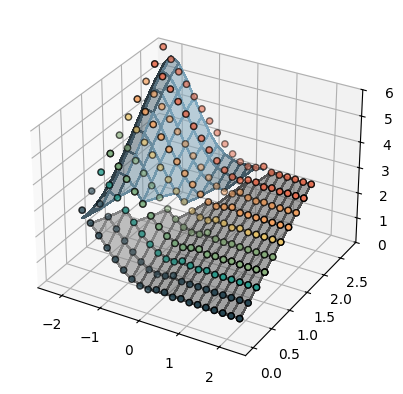

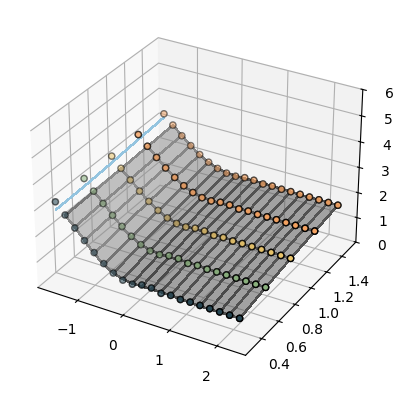

In [16]:
# get the full plot dataset
# -------------------------
X_plot, Y_plot_truth = get_closed_form_data(
    axial=axial, include_extrapolation=True, 
    affine_transform=affine, 
    log_transform=log,
    # no need for nan_interp, nan_extrap inputs yet that's for plotting
    n_rho0=20, n_gamma=10, n_xi=5,
)

# make predictions on the plot data
# ---------------------------------
x_plot_L = tf.expand_dims(X_plot, axis=1)
K_cross = SE_kernel(x_plot_L, x_train_R, th)
Y_plot_pred = np.dot(K_cross, alpha_train)

# plot the surrogate model surface
# --------------------------------

#    can we separately plot the interp and extrap parts of our data,
#    with manual nan on extrap vs interp regions
Y = Y_plot_pred
Y_plot_pred_extrap = nan_extrap_data(X_plot, Y, log=log, affine=affine,
                                     nan_extrap=False)
Y_plot_pred_interp = nan_extrap_data(X_plot, Y, log=log, affine=affine,
                                     nan_extrap=True)

# plot with gamma
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
colors = ["blue", "gray"]
for i,Yp in enumerate([Y_plot_pred_extrap, Y_plot_pred_interp]):
    plot_surface(X_plot, Y=Yp, 
        Y_truth=Y_plot_truth,
        surf_color_map=colors[i],
        var_exclude_ind=2, 
        nx1=20, nx2=10,
        var_exclude_range=[0.3]*2,
        ax=ax, show=False)
ax.set_zlim(0.0, 6.0)
plt.show()

# plot with xi
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
colors = ["blue", "gray"]
for i,Yp in enumerate([Y_plot_pred_extrap, Y_plot_pred_interp]):
    plot_surface(X_plot, Y=Yp, 
        Y_truth=Y_plot_truth,
        surf_color_map=colors[i],
        var_exclude_ind=1, 
        nx1=20, nx2=5,
        var_exclude_range=[0.0]*2,
        ax=ax, show=False)
ax.set_zlim(0.0, 6.0)
plt.show()

In [17]:
# compute the interpolation error
# ------------------------------

x_test_L = tf.expand_dims(X_test, axis=1)
K_cross_test = SE_kernel(x_test_L, x_train_R, th)
Y_test_pred = np.dot(K_cross_test, alpha_train)
sq_diff = (Y_test - Y_test_pred)**2
test_interp_RMSE = np.sqrt(np.mean(sq_diff))
print(f"{test_interp_RMSE=}")

xd.shape=TensorShape([65, 580, 3])
test_interp_RMSE=0.032534891975828685


In [18]:
# compute the extrapolation error
# -------------------------------

# get the extrapolation dataset
X_extrap, Y_extrap_truth = get_closed_form_data(
    axial=axial, 
    include_extrapolation=True,
    include_interpolation=False, 
    affine_transform=affine, 
    log_transform=log,
    # no need for nan_interp, nan_extrap inputs yet that's for plotting
    n_rho0=20, n_gamma=10, n_xi=5,
)

x_extrap_L = tf.expand_dims(X_extrap, axis=1)
K_cross_extrap = SE_kernel(x_extrap_L, x_train_R, th)
Y_extrap_pred = np.dot(K_cross_extrap, alpha_train)
sq_diff_extrap = (Y_extrap_truth - Y_extrap_pred)**2
test_extrap_RMSE = np.sqrt(np.mean(sq_diff_extrap))
print(f"{test_extrap_RMSE=}")

xd.shape=TensorShape([355, 580, 3])
test_extrap_RMSE=0.5479059515791733
